<a href="https://colab.research.google.com/github/LLAlex85/CPP/blob/master/Proyecto_Clasificacion_Localizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyecto 1. Clasificacion y localizacion

El proyecto esta separado en dos partes. La primera parte esta dedicada a resolver el problema de la clasificacion. Se usa EfficientNetB3 como arquitectura. Primero se entrena la red con el top apropiado para la clasificacion. 

La segunda parte agrega una rama para la localizacion. Se usa GIoU como metrica y funcion de perdida (1-GIoU).

#Parte 1. Crea Set de Datos de Validación, Prueba y Entrenamiento

Importa librerías necesarias

In [1]:
import cv2 as cv
import random
import tensorflow as tf
from tensorflow.data import AUTOTUNE
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import gc

Se monta drive para usar dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Descomprime Set de Datos

In [3]:
!unzip /content/drive/MyDrive/tiny-imagenet-200.zip -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: ./tiny-imagenet-200/val/images/val_9

Crea variables para folders que contienen imágenes y anotaciones

In [4]:
data_path = "/content/tiny-imagenet-200"
train_path = "/content/tiny-imagenet-200/train"
test_path = "/content/tiny-imagenet-200/test"
validation_path = "/content/tiny-imagenet-200/val"
classes_file = "wnids.txt"

classes_folders = open(os.path.sep.join([data_path, classes_file])).read().splitlines()

Crea 2 funciones para preprocesar las anotiaciones. Las anotacinoes para el entrenamiento y la validación son diferentes por ende se usan dos funciones. La clasificacion se cambia a un one hot vector que es representado por strings separado por comas

In [5]:
from tensorflow.python.ops.array_ops import zeros
def preprocess_annotation(img_src, annotation, image_class, classes):
  filename, x_min, y_min, x_max, y_max = annotation.split("\t")
  img_path = img_src + "/" + filename
  img = cv.imread(img_path)
  h, w, _ = img.shape

  zero_string = ",0"*200
  index = classes.index(image_class)*2
  new_string = zero_string[0: index +1] + "1" + zero_string[index + 2 : ]

  annotation = "".join([img_path, ",", str(classes.index(image_class)),",",
                        str(float(x_min)/w), ",",
                        str(float(y_min)/h), ",",
                        str(float(x_max)/w), ",",
                        str(float(y_max)/h), new_string ])
  return annotation 

def preprocess_validation_annotation(img_src, annotation, classes):
  filename, image_class , x_min, y_min, x_max, y_max = annotation.split("\t")
  img_path = img_src + "/" + filename
  img = cv.imread(img_path)
  h, w, _ = img.shape

  #Crea one hot vector basado en strings
  zero_string = ",0"*200
  index = classes.index(image_class)*2
  new_string = zero_string[0: index +1] + "1" + zero_string[index + 2: ]

  annotation = "".join([img_path, ",", str(classes.index(image_class)),",",
                        str(float(x_min)/w), ",",
                        str(float(y_min)/h), ",",
                        str(float(x_max)/w), ",",
                        str(float(y_max)/h), new_string])
  return annotation #, class_out

Crea dataset de entrenamiento, validación y prueba.
La forma de crear la lista de muestras está hardcodeada al formato de folders

In [6]:
def build_datasets(train_path, classes_folders, val_path, test_path, index=0):

  random.seed(12357)
  train_examples = []
  for folder in classes_folders:
    annotation_file = os.path.sep.join([train_path, folder, folder + "_boxes.txt"])
    images_path = os.path.sep.join([train_path, folder, "images"])
    train_annotations = open(annotation_file).read().splitlines()

    for item in train_annotations:
      train_examples.append(preprocess_annotation(images_path, item, folder, classes_folders))
  
  random.shuffle(train_examples)

  val_annotations = open(os.path.sep.join([val_path, "val_annotations.txt"])).read().splitlines()
  images_path = os.path.sep.join([val_path,"images"])
  val_examples = [ preprocess_validation_annotation(images_path, item, classes_folders) for item in val_annotations ]
  random.shuffle(val_examples)

  test_images = os.listdir(os.path.sep.join([test_path, "images"]))
  test_examples = [os.path.sep.join([test_path, "images", item]) for item in test_images]
  random.shuffle(test_examples)


  return train_examples , val_examples, test_examples

Crea set de datos para entrenamiento, validación y pruebas

In [7]:
train_data, validation_data, test_dataset = build_datasets(train_path, classes_folders, validation_path, test_path, 0)

Prueba salida de la creación de set de datos. 
Se debe regresar el path de la imagen, el número de clase, su bounding box y la clase en one hot encoding

In [8]:
n_sample = 45
print(train_data[n_sample])
print(classes_folders[ int( train_data[n_sample].split(",")[1] )  ])

/content/tiny-imagenet-200/train/n04398044/images/n04398044_315.JPEG,71,0.21875,0.171875,0.8125,0.59375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
n04398044


Crea función para carga de datos
La función lee imagen, rescala valores enre 0 y 1.0, rescala dimesiones a 64x64x3, obtiene el bounding box y un tensor de salida de one hot enconding para la clase

In [9]:
def loadExample(example):
  # Extraer de la cadena image, bbox 
  str_tensors = tf.strings.split(example, sep=",")
  
  # Cargar la imagen
  img = tf.io.read_file(str_tensors[0])
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, dtype=tf.float32)
  #img = tf.image.resize(img, (64,64))

  #numero de clase 0-199
  num_class = tf.strings.to_number(str_tensors[1])

  x_min = tf.strings.to_number(str_tensors[2])
  y_min = tf.strings.to_number(str_tensors[3])
  x_max = tf.strings.to_number(str_tensors[4])
  y_max = tf.strings.to_number(str_tensors[5])

  #tensor de one hot encoding
  out_class = [tf.strings.to_number(str_tensors[i]) for i in range(6, 206)]

  bbox = [x_min, y_min, x_max, y_max]
          
  return img, out_class

Prueba carga de datos.
La clase en one hot encoding es un tensor de 1 dimensión ( 1D array). Esto está por verificarse si funciona en el entrenamiento ya que el bounding box cada salida es un tensor de un solo escalar. 

In [10]:
img, bbox = loadExample(train_data[45])
classes_folders[np.argmax(bbox)]

'n04398044'

Crea función para aumentar datos, realiza cambio de ilumunación, y de forma aleatoria transforma la imagen (flip let-right y/o flip up-down)

In [11]:
def image_augmentation_2(img, label):

  img = tf.image.random_brightness(img, 0.1)
  img = tf.image.random_flip_left_right(img)
    
  return (img, label)

Prueba loadExample

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(

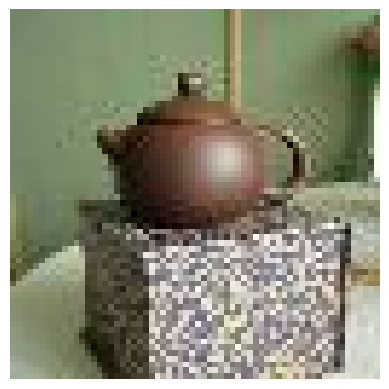

In [12]:
img, label = loadExample(train_data[45])
plt.axis('off')
plt.imshow(img)
print(label)

Prueba aumento de imágenes

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(

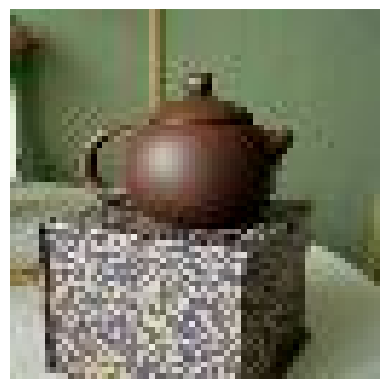

In [13]:
(img, label) = image_augmentation_2(img, label)
plt.axis('off')
plt.imshow(img)
print(label)

Crea Pipeline para entrenamiento y validación

In [14]:
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = (train_dataset
                 .shuffle(len(train_data))
                 .map(loadExample, num_parallel_calls=AUTOTUNE) 
                 .map(image_augmentation_2, num_parallel_calls=AUTOTUNE)               
                 .cache()
                 .batch(batch_size)
                 .prefetch(AUTOTUNE)
                 )

# .map(image_augmentation, num_parallel_calls=AUTOTUNE)
# 

val_dataset = tf.data.Dataset.from_tensor_slices(validation_data)
val_dataset = (val_dataset
                 .shuffle(len(validation_data))
                 .map(loadExample, num_parallel_calls=AUTOTUNE)
                 .cache()
                 .batch(batch_size)
                 .prefetch(AUTOTUNE)
                 )

Prueba iterador 

(16, 64, 64, 3)


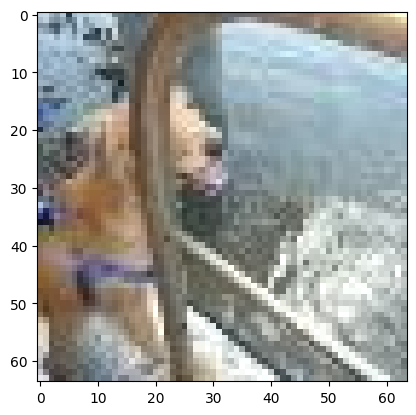

In [15]:
X, Y = next(train_dataset.as_numpy_iterator())
plt.imshow(X[1].reshape((64,64,3)))
print(X.shape)

In [16]:
print(classes_folders[np.argmax(Y[1])])

n02099601


#Define y Crea Modelo. Usa EfficientNet como primera Etapa

EfficientNetB3 se vuelve entrenable con pesos predeterminados

In [17]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization, Resizing
from tensorflow.keras import Model
import tensorflow.keras as keras

In [18]:
input_tensor = Input(shape=(64,64, 3))
resize_tensor = Resizing(224,224)(input_tensor)

vgg = EfficientNetB3(weights="imagenet", include_top=False, input_tensor=resize_tensor, classes=200)

vgg.trainable = True            
vgg_output = vgg.output        # Hacemos referencia al tensor de salida 

43941136/43941136 [==============================] - 3s 0us/step


In [19]:
vgg.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['resizing[0][0]']               
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                     

#Define Etapas Finales Para Clasificación. 

Agrega etapa final para clasificacion de 200 clases. Por lo que se usan 200 neuraonas con salida softmax

In [20]:
x_class_tensor = Flatten()(vgg_output)
x_class_tensor = Dropout(rate=0.4)(x_class_tensor)
output_class_tensor = Dense(200, activation="softmax", name = "output_class")(x_class_tensor)

myVggNet = Model(inputs=input_tensor, outputs=output_class_tensor)
myVggNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['resizing[0][0]']               
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                              

Crea callback para reducir leraning rate cuando no mejore la perida despues de 3 intentos. Usa categoralical_crossentropy como funcion de perdidad para la clasificacion

In [21]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-6)
myVggNet.compile(loss={"output_class": "categorical_crossentropy"}, 
                 optimizer=keras.optimizers.Adam(learning_rate= 0.00005, epsilon= 1e-08), 
                 metrics={"output_class": ["accuracy"]})

Grafica modelo

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.761811 to fit



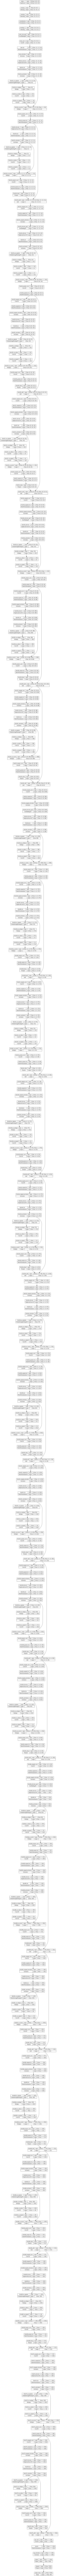

In [22]:
keras.utils.plot_model(myVggNet, to_file="myVggNet.png", show_shapes=True)

#Entrena Modelo.....

Define donde guardar el modelo como mejor rendimiento. Este directorio muestra el modelo penultimo con mejor rendimiento. Caraga modelo con datos de entrenamientos pasados

In [23]:
checkpoint_path  = "/content/drive/MyDrive/model_proy_augmentation_class_3/model_proy_augmentation_class.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss')

latest = tf.train.latest_checkpoint(checkpoint_dir)
myVggNet.load_weights(latest)
myVggNet.evaluate(val_dataset)

625/625 [==============================] - 47s 56ms/step - loss: 2.7730 - accuracy: 0.7527


[2.77297306060791, 0.7526999711990356]

Entrena modelo de clasificacion si es necesario otro entrenenamiento

In [ ]:
myVggNet_mse_accuray = myVggNet.fit(train_dataset, epochs = 15, validation_data = val_dataset, verbose=1,callbacks=[lr_reducer, cp_callback])

#Parte 2. Verifica que modelo obtiene una pérdida menor val_loss:

Usa mejor modelo cuya perdida de validacion fue la menor. (model_proy_augmentation_class_3)

In [32]:
checkpoint_path  = "/content/drive/MyDrive/model_proy_augmentation_class_3/model_proy_augmentation_class.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
myVggNet.load_weights(latest)
myVggNet.evaluate(val_dataset)

625/625 [==============================] - 37s 58ms/step - loss: 2.7730 - accuracy: 0.7527


[2.772972822189331, 0.7526999711990356]

#Carga muestras con imagen y bounding box

Crea las funciones de carga y aumento de datos para la segunda etapa

In [24]:
def loadExample2(example):
  # Extraer de la cadena image, bbox 
  str_tensors = tf.strings.split(example, sep=",")
  
  # Cargar la imagen
  img = tf.io.read_file(str_tensors[0])
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, dtype=tf.float32)
  #img = tf.image.resize(img, (64,64))

  #numero de clase 0-199
  num_class = tf.strings.to_number(str_tensors[1])

  x_min = tf.strings.to_number(str_tensors[2])
  y_min = tf.strings.to_number(str_tensors[3])
  x_max = tf.strings.to_number(str_tensors[4])
  y_max = tf.strings.to_number(str_tensors[5])

  #tensor de one hot encoding
  out_class = [tf.strings.to_number(str_tensors[i]) for i in range(6, 206)]

  bbox = [x_min, y_min, x_max, y_max]
          
  return img, (bbox, out_class)
  

El aumento de datos tambien invierte imagenes y ajusta los valores del boundix box

In [25]:
def image_augmentation(img, label):

  # Realicemos flip horizontal y ajustemos la iluminación
  img = tf.image.random_brightness(img, 0.1)
  bbox = label[0]
  bbox_tr = tf.reshape(bbox, [1,4])

  def lr_transform(img, bbox_tr):
    lr = tf.constant([[0.0, 0.0, -1.0, 0.0],
                      [0.0, 1.0, 0.0, 0.0],
                      [-1.0, 0.0, 0.0, 0.0],
                      [0.0, 0.0, 0.0, 1.0]])

    lr1 = tf.constant([1.0, 0.0, 1.0, 0.0])
    
    img = tf.image.flip_left_right(img)
    bbox_tr = tf.matmul(bbox_tr, lr)
    bbox_tr = tf.add(lr1, bbox_tr)

    return img, bbox_tr

  def up_transform(img, bbox_tr):
    ud = tf.constant([[1.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, -1.0],
                    [0.0, 0.0, 1.0, 0.0],
                    [0.0, -1.0, 0.0, 0.0]])
  
    ud1 = tf.constant([0.0, 1.0, 0.0, 1.0])

    img = tf.image.flip_up_down(img)
    bbox_tr = tf.matmul(bbox_tr, ud)
    bbox_tr = tf.add(bbox_tr, ud1)

    return img, bbox_tr

  def indentity(img, bbox_tr):
    return img, bbox_tr

  condition1 = tf.random.uniform(shape=([1]), minval=0, maxval=100) 
  img, bbox_tr = tf.cond(condition1 > 50, lambda: lr_transform(img, bbox_tr), lambda: indentity(img, bbox_tr))
 
  bbox_tr = tf.reshape(bbox_tr, [4])

  return (img, (bbox_tr, label[1]))

#Carga modelo con pesos para solo clasificación

In [35]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
myVggNet.load_weights(latest)

In [26]:
myVggNet.trainable = True
bbox_input = myVggNet.get_layer('top_activation').output
class_output = myVggNet.output

Agrega segunda rama para regresion del bounding box

In [27]:
x_bbox_tensor = Flatten()(bbox_input)
x_bbox_tensor = Dropout(rate=0.4)(x_bbox_tensor)
x_bbox_tensor = Dense(1024, activation="sigmoid")(x_bbox_tensor)
x_bbox_tensor = Dense(512, activation="sigmoid")(x_bbox_tensor)
output_bbox_tensor = Dense(4, name = "output_bbox")(x_bbox_tensor)

ClassBBoxModel = Model(inputs=input_tensor, outputs=[output_bbox_tensor, class_output])
ClassBBoxModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['resizing[0][0]']               
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                            

Grafica modelo con dos ramas

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.757916 to fit



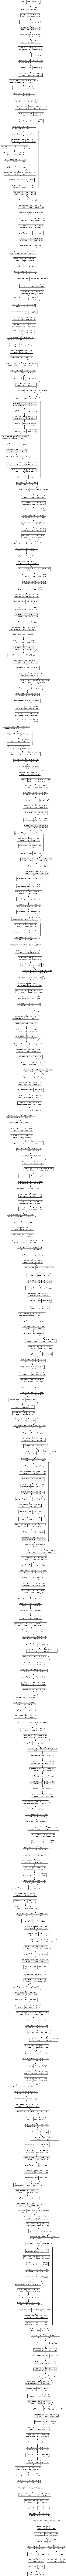

In [28]:
keras.utils.plot_model(ClassBBoxModel, to_file="ClassBbox.png", show_shapes=True)

Define metrica y funcion de perdida para bounding box

In [29]:
def GIoU(bbox_true, bbox_pred):

  zero = tf.convert_to_tensor(0.0, bbox_true.dtype)
  Ax1, Ay1, Ax2, Ay2 = tf.unstack(bbox_true, 4, axis=-1)
  Bx1, By1, Bx2, By2 = tf.unstack(bbox_pred, 4, axis=-1)

  # Para el bounding box predicho: asegurar que Bx2 > Bx1 y By2 > By1
  bx1 = tf.math.minimum(Bx1, Bx2)
  by1 = tf.math.minimum(By1, By2)
  bx2 = tf.math.maximum(Bx1, Bx2)
  by2 = tf.math.maximum(By1, By2)
  
  #Calcular el área del bounding box verdadero
  A_area = (Ax2-Ax1)*(Ay2-Ay1)
  
  #Calcular el área del bounding box predicho  
  B_area = (bx2-bx1)*(by2-by1)
  
  #Calcular la intersección entre los bounding box A y B
  x_inter_1 = tf.math.maximum(bx1, Ax1) 
  y_inter_1 = tf.math.maximum(by1, Ay1)
  x_inter_2 = tf.math.minimum(bx2, Ax2) 
  y_inter_2 = tf.math.minimum(by2, Ay2)

  w_inter = tf.maximum(zero, x_inter_1 - x_inter_2)
  h_inter = tf.maximum(zero, y_inter_1 - y_inter_2)  

  I = w_inter * h_inter

  area_union = (B_area + A_area) - I
  iou = tf.math.divide_no_nan(I, area_union)

  #Encontrar el Bbox C más pequeño que abarque a los bboxes A y B
  Cx1 = tf.math.minimum(bx1, Ax1)
  Cy1 = tf.math.minimum(by1, Ay1)
  Cx2 = tf.math.maximum(bx2, Ax2)
  Cy2 = tf.math.maximum(by2, Ay2)

  #Calcular el área del bbox C  
  C_area = (Cx2-Cx1) * (Cy2-Cy1)

  giou = iou - tf.math.divide_no_nan(C_area-area_union, C_area)
  m_giou = tf.reduce_mean(giou,axis=0)
  return m_giou

In [30]:
def GIoU_loss(bbox_true, bbox_pred):
  return 1.0 - GIoU(bbox_true, bbox_pred)

Define funciones de perdidad para cada rama

In [31]:
ClassBBoxModel.compile(loss={"output_bbox": GIoU_loss, "output_class": "categorical_crossentropy"}, 
                 optimizer=keras.optimizers.Adam(learning_rate= 0.00001, epsilon= 1e-08), 
                 metrics={"output_bbox": [GIoU], "output_class": ["accuracy"]})

Crea pipeline para carga y aumento de datos de imagen y boundig box

In [32]:
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = (train_dataset
                 .shuffle(len(train_data))
                 .map(loadExample2, num_parallel_calls=AUTOTUNE) 
                 .map(image_augmentation, num_parallel_calls=AUTOTUNE)               
                 .cache()
                 .batch(batch_size)
                 .prefetch(AUTOTUNE)
                 )

val_dataset = tf.data.Dataset.from_tensor_slices(validation_data)
val_dataset = (val_dataset
                 .shuffle(len(validation_data))
                 .map(loadExample2, num_parallel_calls=AUTOTUNE)
                 .cache()
                 .batch(batch_size)
                 .prefetch(AUTOTUNE)
                 )

Define donde guardar el moejor modelo con ambas ramas

In [35]:
checkpoint_path  = "/content/drive/MyDrive/model_proy_augmentation_class_bbox3/model_proy_augmentation_class_bbox.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss')

latest = tf.train.latest_checkpoint(checkpoint_dir)
ClassBBoxModel.load_weights(latest)

In [36]:
ClassBBoxModel_history = ClassBBoxModel.fit(train_dataset, epochs = 5, validation_data = val_dataset, verbose=1,callbacks=[lr_reducer, cp_callback])

Epoch 1/5
6250/6250 [==============================] - ETA: 0s - loss: 0.4402 - output_bbox_loss: 0.3634 - output_class_loss: 0.0768 - output_bbox_GIoU: 0.6366 - output_class_accuracy: 0.9814
Epoch 1: val_loss improved from inf to 2.97819, saving model to /content/drive/MyDrive/model_proy_augmentation_class_bbox3/model_proy_augmentation_class_bbox.ckpt
6250/6250 [==============================] - 1834s 278ms/step - loss: 0.4402 - output_bbox_loss: 0.3634 - output_class_loss: 0.0768 - output_bbox_GIoU: 0.6366 - output_class_accuracy: 0.9814 - val_loss: 2.9782 - val_output_bbox_loss: 0.3988 - val_output_class_loss: 2.5794 - val_output_bbox_GIoU: 0.6012 - val_output_class_accuracy: 0.7907 - lr: 5.0000e-07
Epoch 2/5
6250/6250 [==============================] - ETA: 0s - loss: 0.4331 - output_bbox_loss: 0.3619 - output_class_loss: 0.0712 - output_bbox_GIoU: 0.6381 - output_class_accuracy: 0.9822
Epoch 2: val_loss improved from 2.97819 to 2.96945, saving model to /content/drive/MyDrive/model

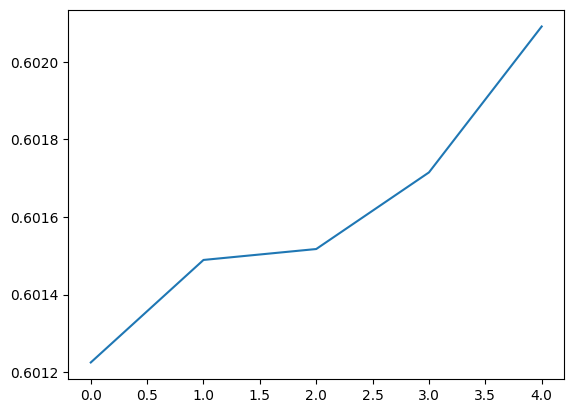

In [38]:
plt.plot(ClassBBoxModel_history.history['val_output_bbox_GIoU'])



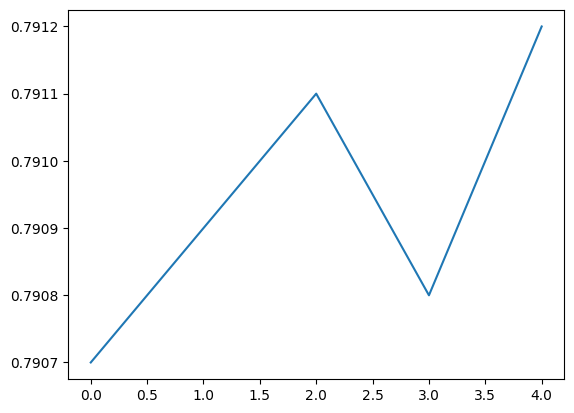

In [39]:
plt.plot(ClassBBoxModel_history.history['val_output_class_accuracy'])

#Evalua set de datos de evaulación

In [40]:
ClassBBoxModel.evaluate(val_dataset)

625/625 [==============================] - 35s 56ms/step - loss: 2.9418 - output_bbox_loss: 0.3979 - output_class_loss: 2.5439 - output_bbox_GIoU: 0.6021 - output_class_accuracy: 0.7912


[2.941777467727661,
 0.39790892601013184,
 2.543870210647583,
 0.6020909547805786,
 0.7911999821662903]

#Prueba Test Data Set

In [41]:
#Función para cargar imagen de prueba
def load_test_image(path):
   # Extraer de la cadena image, bbox 
  str_tensors = tf.strings.split(path, sep=",")
  
  # Cargar la imagen
  img = tf.io.read_file(str_tensors[0])
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, dtype=tf.float32)
  
  return tf.reshape(img, [1,64,64,3])

In [77]:
def get_prediction(img_path):
  img = load_test_image(img_path)
  bbox, classification = ClassBBoxModel.predict(img)
  bbox = bbox * 64.0
  class_folder = classes_folders[np.argmax(classification[0])]
  #El modelo parece que cambia los tensores del bbox
  x_min = max(0, int(bbox[0][2]))
  y_min = max(0, int(bbox[0][3]))
  x_max = min(63, int(bbox[0][0]))
  y_max = min(63, int(bbox[0][1]))

  return f"{img_path.split('/')[-1]}\t{class_folder}\t{x_min} {y_min} {x_max} {y_max}\n"

#Prueba Prediccion Por imagen

In [95]:
print(get_prediction('/content/tiny-imagenet-200/val/images/val_10.JPEG'))

1/1 [==============================] - 0s 44ms/step
val_10.JPEG	n04371430	20 24 55 60



In [ ]:
output_file = open('./Predicciones.txt', 'w')

for sample in test_dataset:
  prediction = get_prediction(sample)
  output_file.write(prediction)
